In [15]:
# Libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import KFold, cross_val_score



In [16]:
# Data upload
df= pd.read_csv("C:/Users/PC-023/Documents/bank/bank-full.csv", sep=";")

# Viewing data
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [17]:
columns_to_keep = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
data = df[columns_to_keep]

In [18]:
# Print the first few rows of the prepared dataset
data.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [19]:
data.tail()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,825,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,1729,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,5715,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,668,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,2971,no,cellular,17,nov,361,2,188,11,other,no


In [20]:
# Split into train, validation, and test sets
data_full_train, data_test = train_test_split(data, test_size=0.2, random_state=1)
data_train, data_val = train_test_split(data_full_train, test_size=0.25, random_state=1)

data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data['y'], test_size=0.2, random_state=1)


In [21]:
# Define target variable
y_train = (data_train['y'] == 'yes').astype(int)

In [22]:
# Calculate AUC for numerical variables
numerical_cols = ['balance', 'day', 'duration', 'previous']
aucs = {}

for col in numerical_cols:
    auc = roc_auc_score(y_train, data_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -data_train[col])  # Invert the variable if AUC is less than 0.5
    aucs[col] = auc

In [23]:
 # Output the feature with the highest AUC
best_feature = max(aucs, key=aucs.get)
print(f"The numerical variable with the highest AUC is: {best_feature} with AUC: {aucs[best_feature]}")

The numerical variable with the highest AUC is: duration with AUC: 0.8147002759670778


In [24]:
# Define target variable 'y'
y_train = (data_train['y'] == 'yes').astype(int)
y_val = (data_val['y'] == 'yes').astype(int)

In [25]:
# One-hot encoding using DictVectorizer
train_dicts = data_train.drop(columns=['y']).to_dict(orient='records')
val_dicts = data_val.drop(columns=['y']).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)


In [26]:
# Train the Logistic Regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [27]:
# Predict probabilities and calculate AUC on the validation set
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f'AUC on the validation set: {auc:.3f}')

AUC on the validation set: 0.900


In [28]:
# Get predicted probabilities from the model
y_pred = model.predict_proba(X_val)[:, 1]

In [29]:
# Initialize lists to store precision and recall values
precisions = []
recalls = []
thresholds = np.arange(0.0, 1.01, 0.01)

for t in thresholds:
    # Convert predicted probabilities to binary predictions based on the threshold
    y_pred_bin = (y_pred >= t).astype(int)
    
    # Compute precision and recall
    precision = precision_score(y_val, y_pred_bin)
    recall = recall_score(y_val, y_pred_bin)
    
    precisions.append(precision)
    recalls.append(recall)

C:\Users\PC-023\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


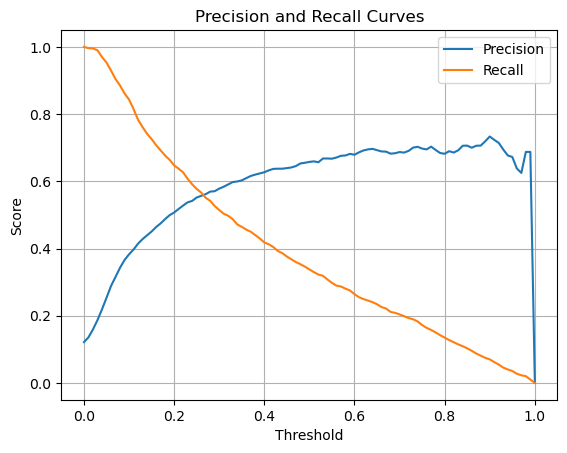

In [30]:
# Plot Precision and Recall curves
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Find the threshold where precision and recall intersect
diffs = np.abs(np.array(precisions) - np.array(recalls))
min_diff_idx = np.argmin(diffs)
best_threshold = thresholds[min_diff_idx]

print(f'Precision and Recall intersect at threshold: {best_threshold:.3f}')

Precision and Recall intersect at threshold: 1.000


In [32]:
# Get predicted probabilities from the model
y_pred = model.predict_proba(X_val)[:, 1]

In [33]:
# Initialize lists to store precision, recall, and F1 scores
f1_scores = []
thresholds = np.arange(0.0, 1.01, 0.01)

for t in thresholds:
    # Convert predicted probabilities to binary predictions based on the threshold
    y_pred_bin = (y_pred >= t).astype(int)

In [34]:
# Compute precision and recall
precision = precision_score(y_val, y_pred_bin)
recall = recall_score(y_val, y_pred_bin)
    
    

C:\Users\PC-023\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
# Compute F1 score
if precision + recall > 0:
 f1 = 2 * (precision * recall) / (precision + recall)
else:
 f1 = 0
 f1_scores.append(f1)


ValueError: x and y must have same first dimension, but have shapes (101,) and (3,)

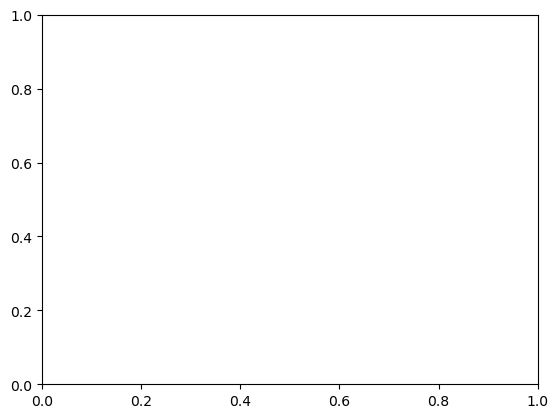

In [39]:
# Plot F1 scores vs thresholds
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.show()

In [40]:
# Find the threshold where F1 score is maximal
max_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_idx]

print(f'Threshold with maximum F1 score: {best_threshold:.2f}')

Threshold with maximum F1 score: 0.00


In [41]:
# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [42]:
# List of C values to test
C_values = [0.000001, 0.001, 1]

In [43]:
# Store the results for each C value
results = []

for C in C_values:
    # Initialize logistic regression with current C
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc')
    
    # Compute mean and standard deviation of the scores
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    
    # Append the result as a tuple (C, mean_score, std_score)
    results.append((C, mean_score, std_score))

    # Print the result for this C
    print(f"C={C}: Mean AUC={mean_score:.3f}, Std={std_score:.3f}")

C=1e-06: Mean AUC=0.698, Std=0.005
C=0.001: Mean AUC=0.853, Std=0.006
C=1: Mean AUC=0.908, Std=0.005


In [44]:
# Sort results first by mean_score (descending), then by std_score (ascending), then by C (ascending)
results.sort(key=lambda x: (-x[1], x[2], x[0]))

# The best C will be the first item in the sorted list
best_C, best_mean, best_std = results[0]

# Output the best C value, mean AUC, and standard deviation
print(f"Best C: {best_C}, with Mean AUC: {best_mean:.3f} and Std: {best_std:.3f}")

Best C: 1, with Mean AUC: 0.908 and Std: 0.005
